'2021-08-31_17_12_40'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
from module.GlobalSeed import seed_everything
from module.DataLoader import MaskDataset
from module.Losses import CostumLoss
from module.F1_score import F1_Loss # ToDo

In [4]:
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
seed_everything(777)

In [7]:
pre_transforms = transforms.Compose([
    #lambda img : transforms.functional.crop(img, 40, 70, 350, 180),
    transforms.Resize((128,128)),
    transforms.Grayscale(),
])
dataset = MaskDataset(
    target         = "total_label",
    realign        = True,
    csv_path       = '../../input/data/train/train.csv',
    images_path    = '../../input/data/train/images/',
    pre_transforms = pre_transforms,
    transforms = transforms.Compose([
        transforms.ToTensor(),
    ]),
    sub_mean = True,
    debug = False
)

  1%|▏         | 23/1766 [00:00<00:07, 225.13it/s]

mask dataset is loading ::::


100%|██████████| 1766/1766 [00:07<00:00, 228.62it/s]


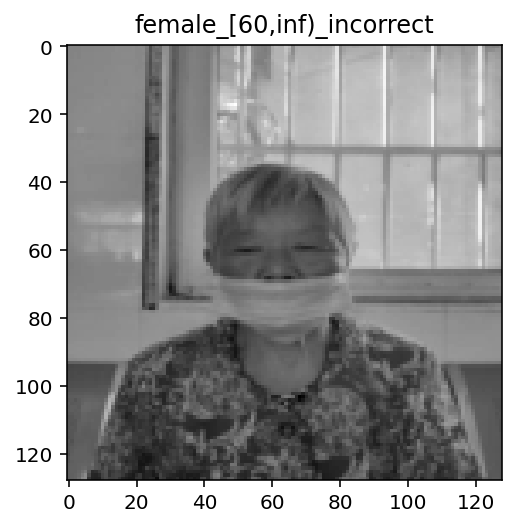

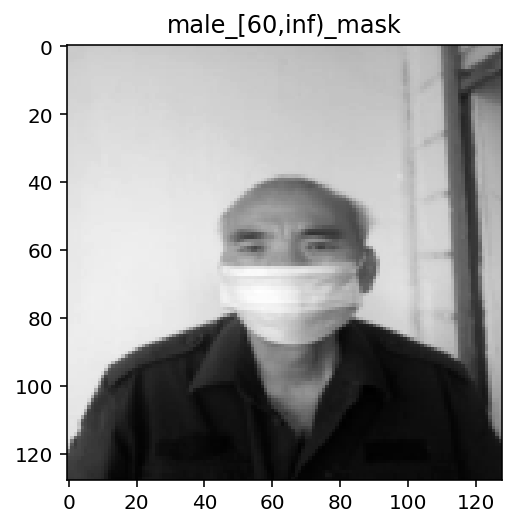

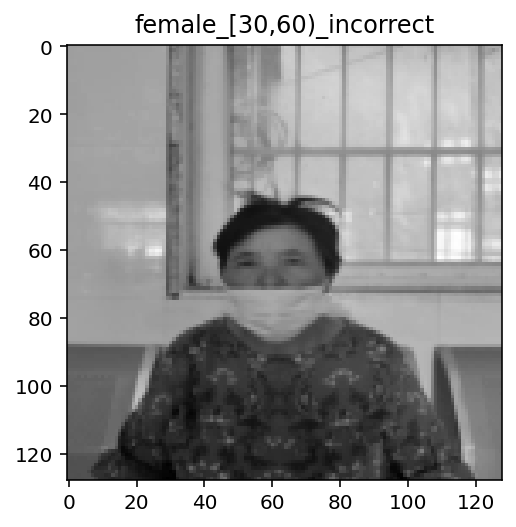

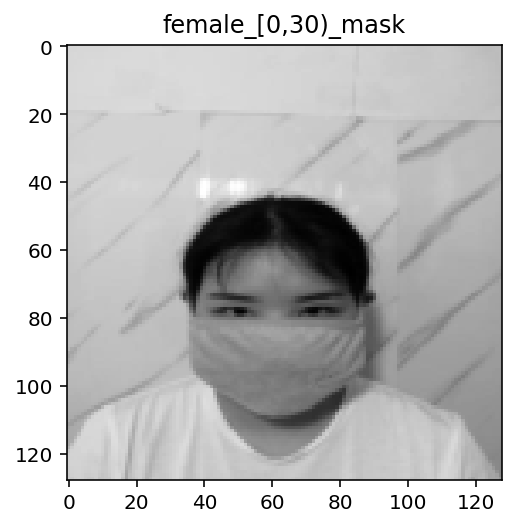

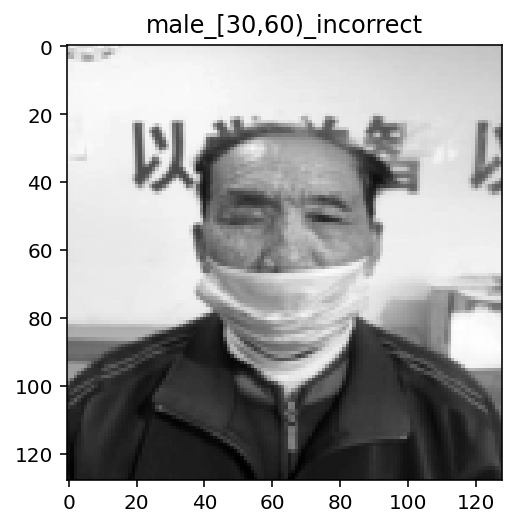

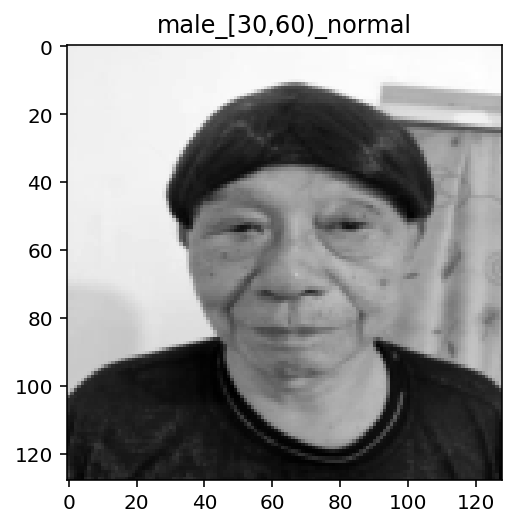

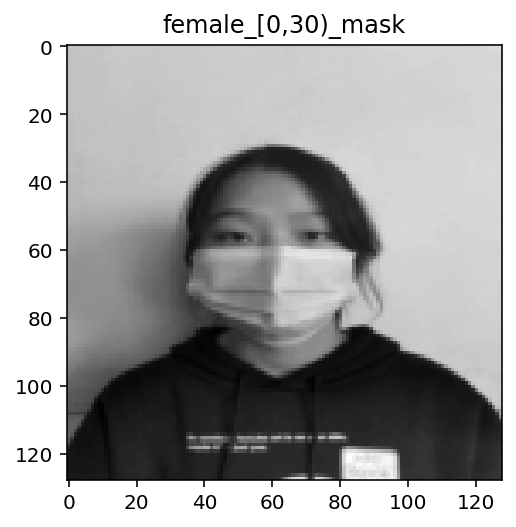

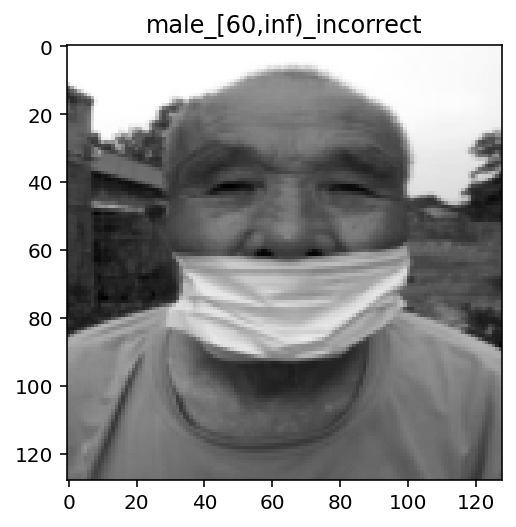

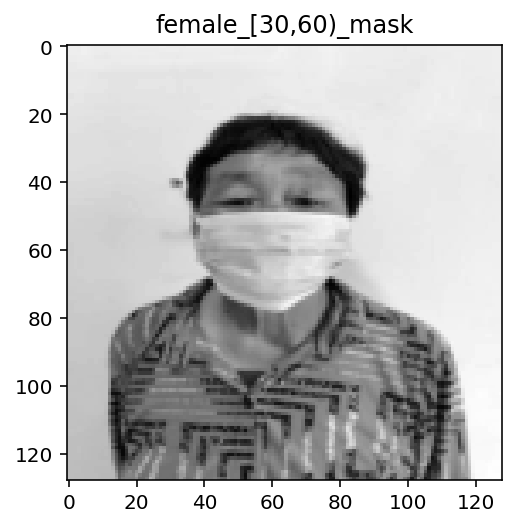

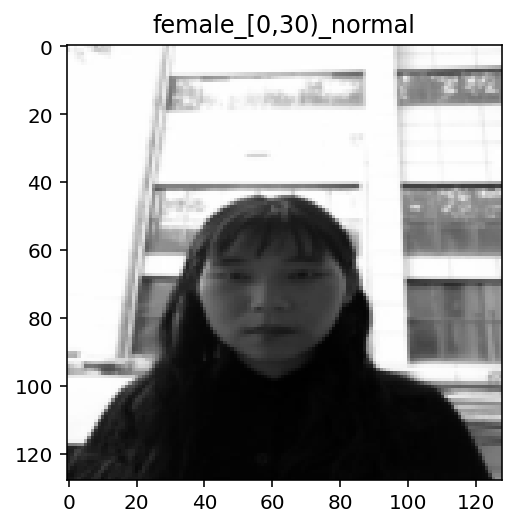

In [8]:
for i in range(10):
    X, y = dataset[i]
    plt.title(dataset.classes[y])
    plt.imshow(X[0],cmap = 'gray')
    plt.show()

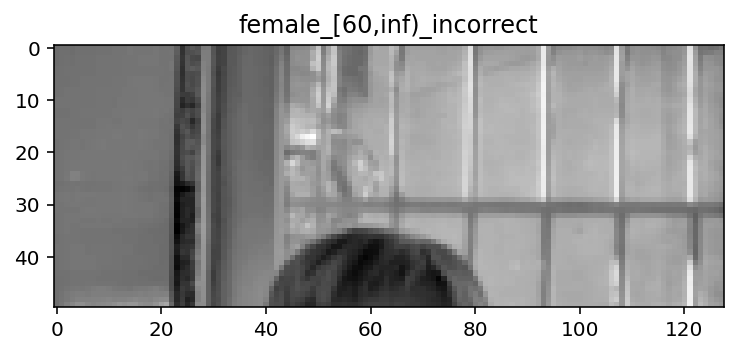

In [9]:
for i in range(1):
    X, y = dataset[i]
    plt.title(dataset.classes[y])
    plt.imshow(X[0][:50],cmap = 'gray')
    plt.show()

In [10]:
# train_len = int(len(dataset) * 0.8)
# size = [train_len, len(dataset) - train_len]
# train_set, val_set = torch.utils.data.random_split(dataset, size)

In [11]:
train_set   = dataset
train_dataloader = DataLoader(
    train_set,
    batch_size  = 32,
    shuffle     = True,
    sampler     = None,
    num_workers = 8,
    drop_last   = True
)
# val_dataloader = DataLoader(
#     val_set,
#     batch_size  = 128,
#     shuffle     = None,
#     sampler     = None,
#     num_workers = 8,
#     drop_last   = True
# )

In [12]:
class RecurrentNeuralNetworkClass(nn.Module):
    def __init__(self,name='rnn',xdim=128,hdim=256,ydim=18,n_layer=3):
        super(RecurrentNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.n_layer = n_layer # K

        self.rnn = nn.LSTM(
            input_size=self.xdim,
            hidden_size=self.hdim,
            num_layers=self.n_layer,
            batch_first=True
        )
        self.lin = nn.Linear(self.hdim,self.ydim)

    def forward(self,x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(
            # FILL IN HERE
            self.n_layer, x.size(0),self.hdim
        ).to(device)
        c0 = torch.zeros(
            # FILL IN HERE
            self.n_layer, x.size(0),self.hdim
        ).to(device)
        # RNN
        rnn_out,(hn,cn) = self.rnn(x, (h0,c0)) 
        # x:[N x L x Q] => rnn_out:[N x L x D]
        # Linear
        out = self.lin(
            # FILL IN HERE
            rnn_out[:, -1, :]
            ).view([-1,self.ydim]) 
        return out 

R = RecurrentNeuralNetworkClass(
    name='rnn',xdim=128,hdim=512,ydim=18,n_layer=3).to(device)
# loss = CostumLoss(
#     lossfn      = "CrossEntropyLoss",
#     #lossfn_2    = "F1",
#     #p           = 0.5,
#     #num_classes = len(dataset.classes),
#     device      = device,
# )
loss = nn.CrossEntropyLoss()
#optm = optim.SGD(R.parameters(),lr=1e-2, momentum = 0.99)
optm = optim.Adam(R.parameters(),lr=3e-4)
print ("Done.")

Done.


In [13]:
np.set_printoptions(precision=5)
torch.set_printoptions(precision=5)

In [14]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.view(-1,128,128).to(device))
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [15]:
train_accr = func_eval(R,train_dataloader,device)
print ("train_accr:[%.3f]."%(train_accr))
#test_accr = func_eval(R,val_dataloader,device)
#print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.057].


In [16]:
print ("Start training.")
R.train() # to train mode 
EPOCHS,print_every = 200,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_dataloader:
        # Forward path
        y_pred = R.forward(batch_in.view(-1,128,128).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_dataloader)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(R,train_dataloader,device)
        #test_accr = func_eval(R,val_dataloader,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr))
print ("Done")
saved_model_path = './saved_model/LSTM/model/'
os.makedirs(saved_model_path, exist_ok = True)
torch.save(R, saved_model_path+'LSTM_%s.pt'%datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))

saved_weights_path = './saved_model/LSTM/weights/'
os.makedirs(saved_weights_path, exist_ok = True)
torch.save(R.state_dict(), saved_weights_path+'/LSTM_%s.pt'%datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))

Start training.
epoch:[0] loss:[2.891] train_accr:[0.072].
epoch:[1] loss:[2.883] train_accr:[0.079].
epoch:[2] loss:[2.874] train_accr:[0.073].
epoch:[3] loss:[2.872] train_accr:[0.085].
epoch:[4] loss:[2.837] train_accr:[0.097].
epoch:[5] loss:[2.812] train_accr:[0.107].
epoch:[6] loss:[2.784] train_accr:[0.111].
epoch:[7] loss:[2.781] train_accr:[0.097].
epoch:[8] loss:[2.776] train_accr:[0.115].
epoch:[9] loss:[2.763] train_accr:[0.123].
epoch:[10] loss:[2.743] train_accr:[0.139].
epoch:[11] loss:[2.717] train_accr:[0.149].
epoch:[12] loss:[2.704] train_accr:[0.144].
epoch:[13] loss:[2.691] train_accr:[0.151].
epoch:[14] loss:[2.672] train_accr:[0.126].
epoch:[15] loss:[2.665] train_accr:[0.164].
epoch:[16] loss:[2.662] train_accr:[0.143].
epoch:[17] loss:[2.657] train_accr:[0.173].
epoch:[18] loss:[2.611] train_accr:[0.188].
epoch:[19] loss:[2.659] train_accr:[0.147].
epoch:[20] loss:[2.740] train_accr:[0.148].
epoch:[21] loss:[2.679] train_accr:[0.154].
epoch:[22] loss:[2.611] tr

KeyboardInterrupt: 

In [17]:
df = pd.read_csv('../../input/data/eval/info.csv')
im_path = '../../input/data/eval/images/'

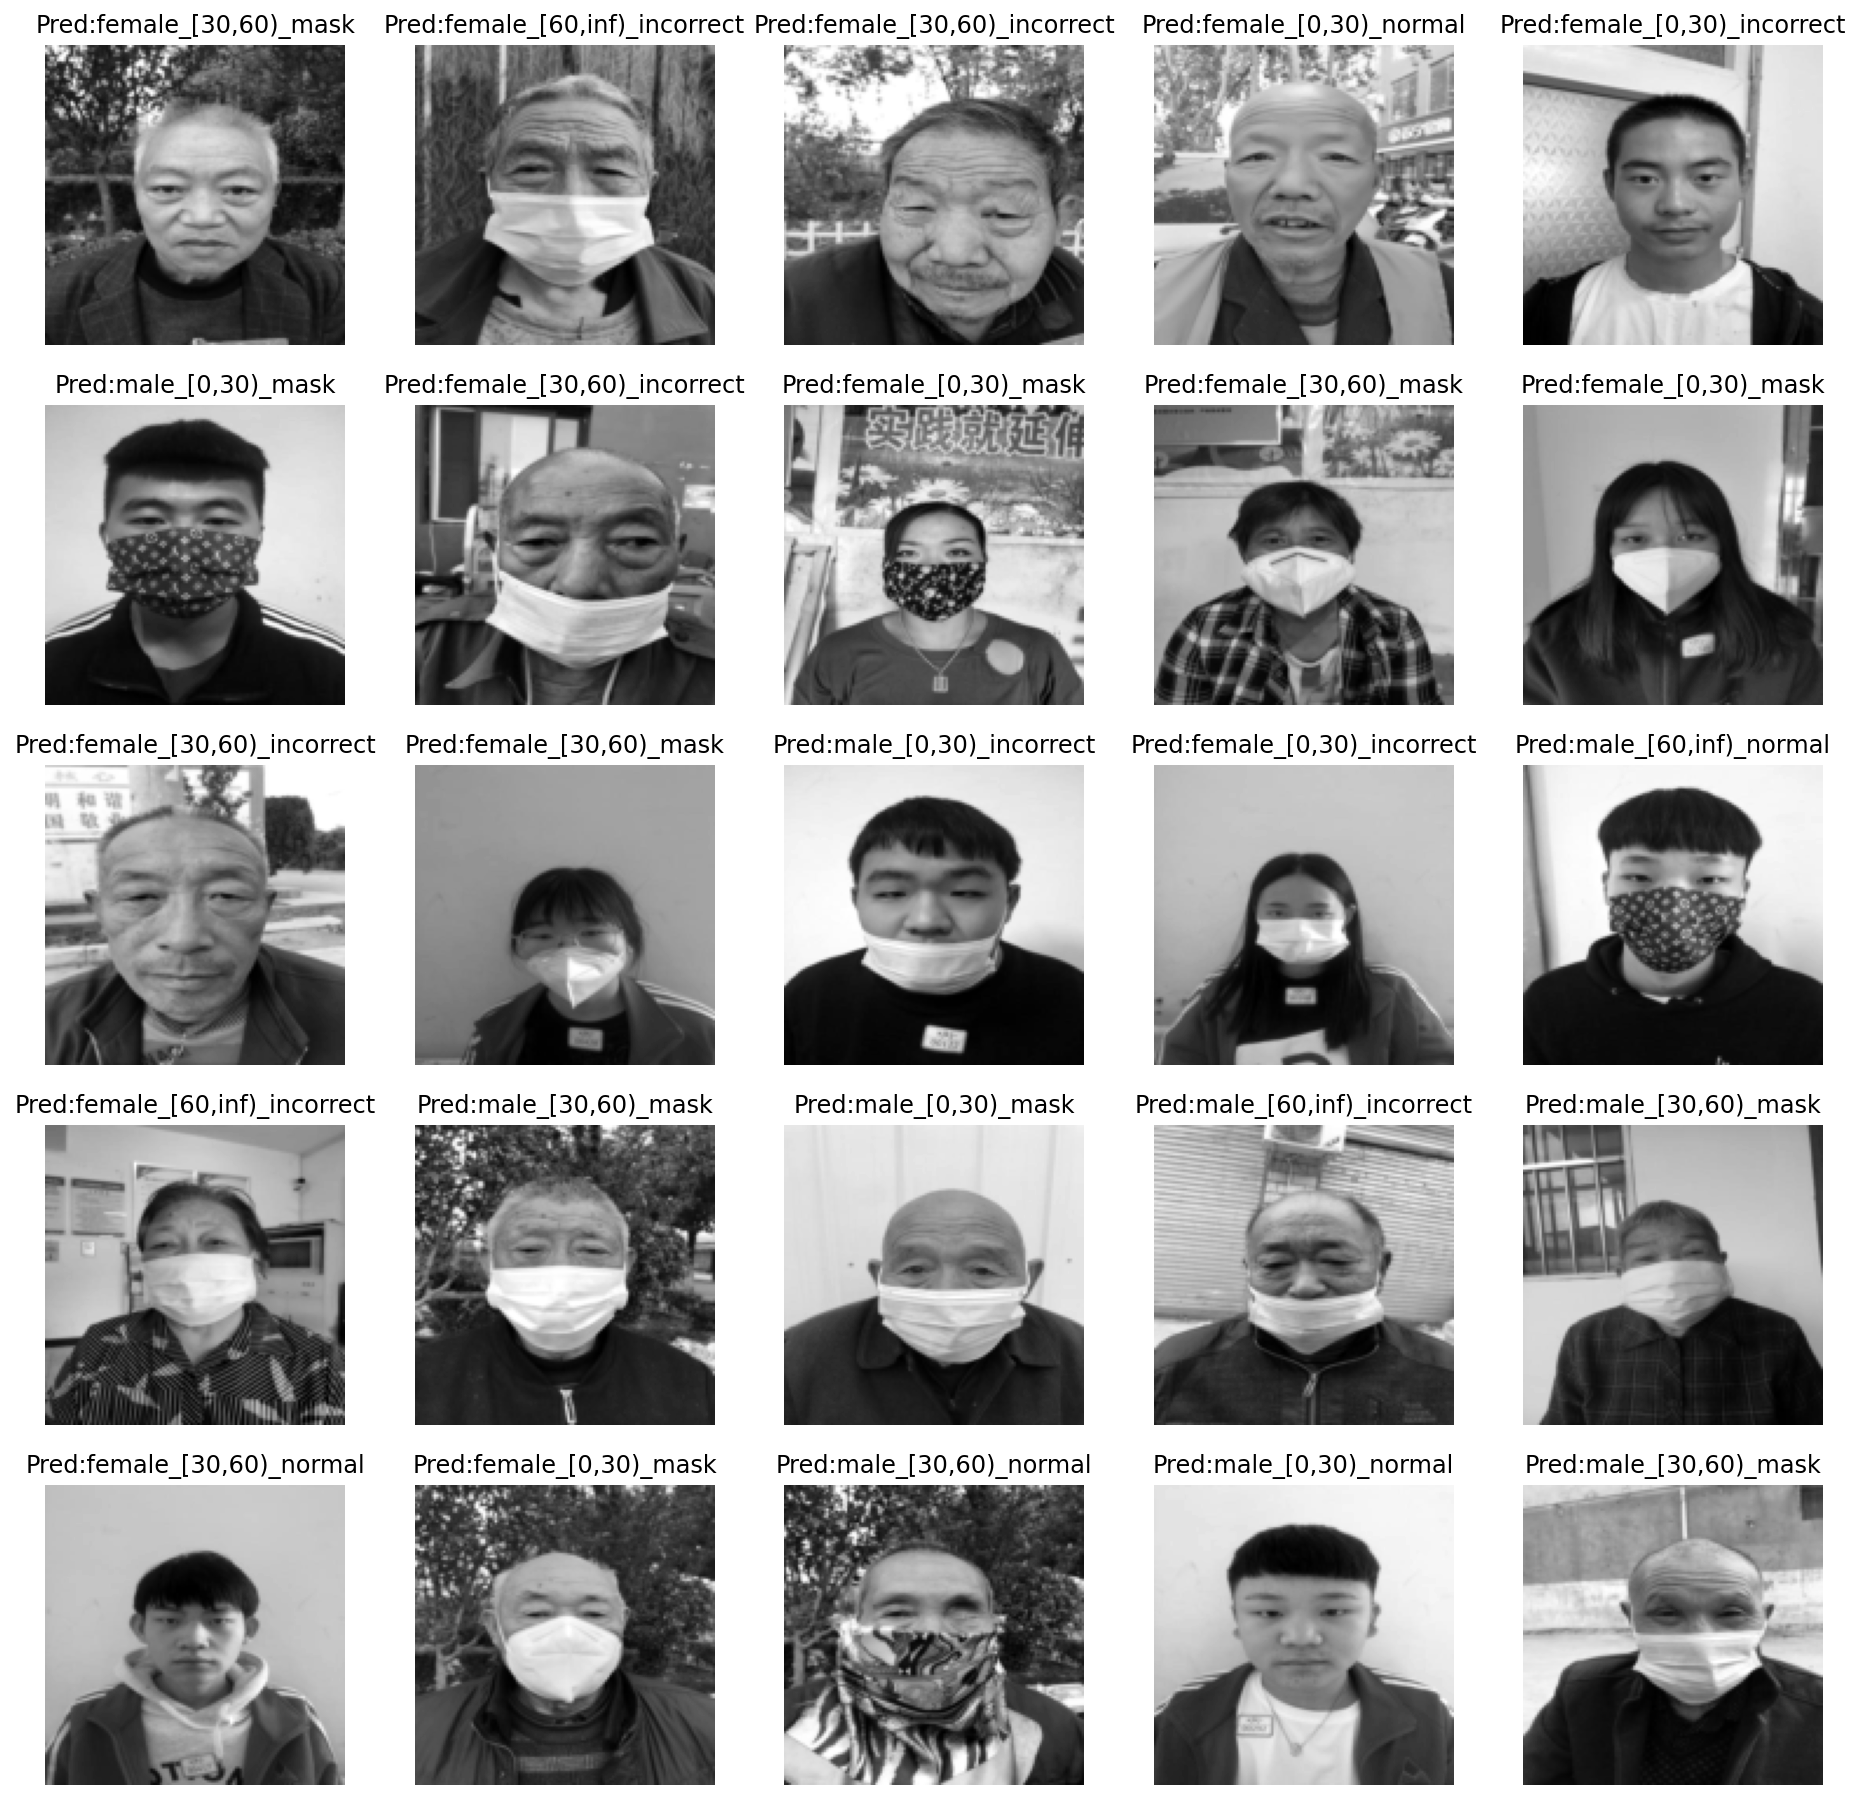

Done


In [18]:
with torch.no_grad():
    R.eval() # to evaluation mode 
        
n_sample = 25
plt.figure(figsize=(16,16))
sample_indices = np.random.choice(len(df),n_sample,replace=False)
for idx,imID in enumerate(df.ImageID[:25]):
    image = Image.open(im_path + imID)
    with torch.no_grad():
        transfromed = transforms.ToTensor()(pre_transforms(image))
        y_pred = R(transfromed.view(-1,128,128).to(device))
        y_pred = y_pred.argmax(axis=1)
        plt.subplot(5, 5, idx+1)
        plt.imshow(transfromed[0], cmap='gray')
        plt.axis('off')
        plt.title("Pred:%s"%(dataset.classes[y_pred[0]]))
plt.show()
print ("Done")

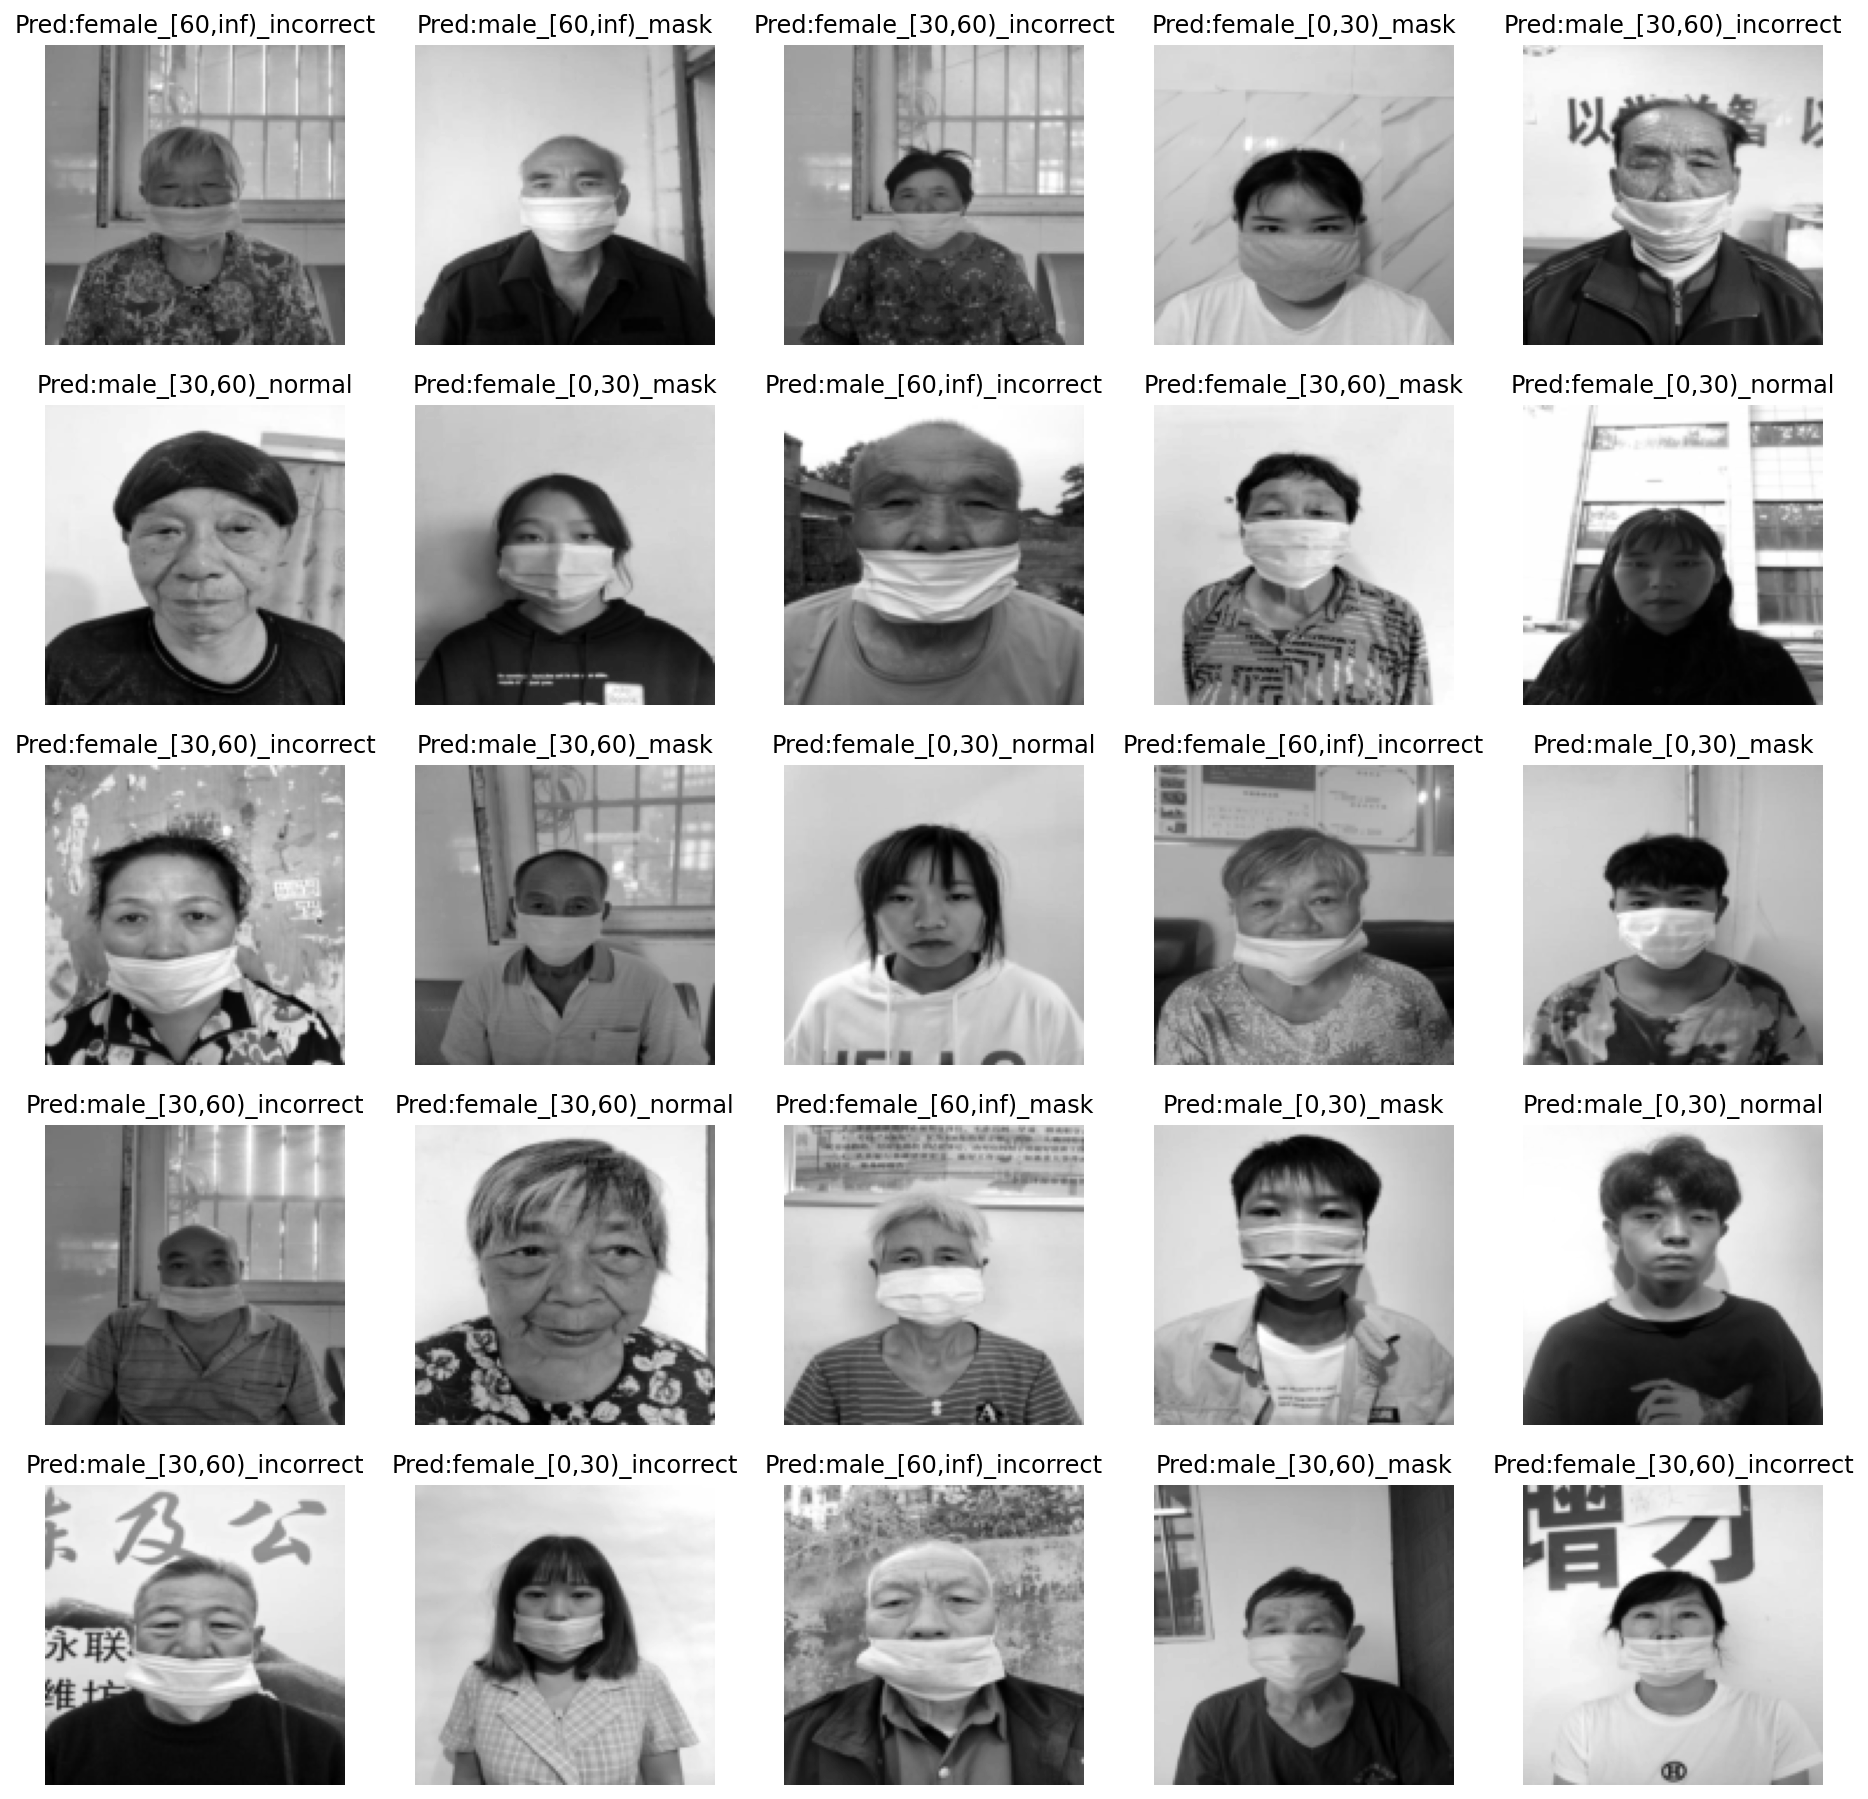

Done


In [19]:
with torch.no_grad():
    R.eval() # to evaluation mode 
        
n_sample = 25
plt.figure(figsize=(16,16))
for idx, (X,y) in enumerate(dataset):
    if n_sample == idx: break
    with torch.no_grad():
        y_pred = R(X.view(-1,128,128).to(device))
        y_pred = y_pred.argmax(axis=1)
        plt.subplot(5, 5, idx+1)
        plt.imshow(X[0], cmap='gray')
        plt.axis('off')
        plt.title("Pred:%s"%(dataset.classes[y_pred[0]]))
plt.show()
print ("Done")

In [ ]:
with torch.no_grad():
    R.eval() # to evaluation mode 
    y_pred = R.forward(X.view(-1,128,128).type(torch.float).to(device)/255.)
    print(dataset.classes[y_pred.argmax(axis=1)])

In [ ]:
(y_pred.argmax(axis=1)==test_y.to(device)).sum().item()

In [ ]:
for idx, (X,y) in enumerate(train_dataloader):
    print(idx)
    print(X)
    input()

In [1]:
from model.ModelLoader import ModelLoader

In [3]:
model = ModelLoader(
    model_name = "resnet18",
    input_shape = [1,3,128,128],
    pretrained = True,
    initializer = None, #"kaiming_uniform_",
    freeze_range = None,
    device = "cuda:0",
)


In [4]:
model.last_layer_modifier(
    in_features= 512,
    out_features=18,
    bias=False,
    W_initializer = "kaiming_uniform_",
    b_initializer = "in_sqrt_uniform"
)

In [5]:
model.release_all_params()

In [18]:
m_list = list(model.named_modules())[15:]
for n, m in m_list:
    print("n : ", n)
    print("m : ", m)
    
    for p in m.parameters():
        print(p.shape)
        input()

n :  model.layer1.1.bn1
m :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])


torch.Size([64])


n :  model.layer1.1.relu
m :  ReLU(inplace=True)
n :  model.layer1.1.conv2
m :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([64, 64, 3, 3])


n :  model.layer1.1.bn2
m :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])


torch.Size([64])


n :  model.layer2
m :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): B

KeyboardInterrupt: Interrupted by user

In [20]:
[0,1,2,3,][1:None]

[1, 2, 3]

In [1]:
from module.DataLoader import MaskDataset, DatasetSplit
import torchvision.transforms as transforms

In [2]:
dataset = MaskDataset(
    target         = "total_label",
    realign        = True,
    csv_path       = '../../input/data/train/train.csv',
    images_path    = '../../input/data/train/images/',
    pre_transforms = transforms.Compose([
        transforms.Resize((64,64)),
    ]),
    transforms = transforms.Compose([
        transforms.ToTensor(),
    ]),
    sub_mean = 0,#hp["SUB_MEAN"],
    debug = 0,#hp["DEBUG"]
)

In [3]:
trset, valset = DatasetSplit(dataset)

  0%|          | 6/1413 [00:00<00:26, 52.65it/s]

mask dataset is loading ::::


  2%|▏         | 8/353 [00:00<00:04, 74.74it/s]

mask dataset is loading ::::


100%|██████████| 353/353 [00:04<00:00, 72.85it/s]


In [4]:
trset.df.head()

ID  Gender   AgeBand MaskState                           FileName  \
12382  004214  female   [30,60)      mask   004214_female_Asian_58/mask2.jpg   
13875  005027  female   [30,60)    normal  005027_female_Asian_53/normal.jpg   
3382   001110    male    [0,30)    normal    001110_male_Asian_25/normal.jpg   
3656   001152    male  [60,inf)      mask     001152_male_Asian_60/mask3.jpg   
12983  004339  female  [60,inf)      mask   004339_female_Asian_60/mask5.jpg   

                       Label  
12382    female_[30,60)_mask  
13875  female_[30,60)_normal  
3382      male_[0,30)_normal  
3656      male_[60,inf)_mask  
12983   female_[60,inf)_mask

In [5]:
valset.df.head()

ID  Gender   AgeBand  MaskState  \
17813  006551  female    [0,30)       mask   
11358  003789    male   [30,60)  incorrect   
15037  005428  female   [30,60)     normal   
8269   003137  female    [0,30)       mask   
11015  003727    male  [60,inf)  incorrect   

                                      FileName                    Label  
17813         006551_female_Asian_20/mask5.jpg       female_[0,30)_mask  
11358  003789_male_Asian_41/incorrect_mask.jpg   male_[30,60)_incorrect  
15037        005428_female_Asian_48/normal.jpg    female_[30,60)_normal  
8269          003137_female_Asian_20/mask3.jpg       female_[0,30)_mask  
11015  003727_male_Asian_60/incorrect_mask.jpg  male_[60,inf)_incorrect